In [ ]:
#hide 

%load_ext autoreload
%autoreload 2

In [ ]:
#default_exp train

# Train
> Training and evaluation of the model using FastAI utilities

In [ ]:
#exporti

from transformers import DistilBertTokenizer
from fastai.data.core import DataLoaders
from fastai.vision.all import *
from DSAI_proj.dataset import *
from DSAI_proj.model import *
from fastai.vision import *
from torch import nn
import torch

First, let's create our loss function. This will tell our model how wrong it is by calculating how far the predictions are from the output. Here, we will use cross entropy loss as our criterion. We can do this by viewing each token as a separate class, and hence provide a one-for-one comparison of tokens at each position.

In [ ]:
#export

class TagLineLoss(nn.Module):
    
    def __init__(self):
        super(TagLineLoss, self).__init__()
        self.criterion = torch.nn.CrossEntropyLoss()
    
    def forward(self, output, target):
        x = F.log_softmax(output, dim=-1).permute(0, 2, 1)
        return self.criterion(input=x, target=target)

We also define a splitter which will group the parameters of the different models to allow for unfreezing of the layers subsequently. 

In [ ]:
#export

def splitter_func(model: nn.Module):
    return [params(model.cnn_encoder),
            params(model.text_encoder),
            params(model.meta_encoder),
            params(model.decoder)]

Same as with the previously, let us create the datasets, then the dataloaders, and followed by the model. 

In [ ]:
# dataset creation
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
poster_img_dir = "poster_img/"
backdrop_img_dir = "backdrop_img/"
input_max_length, labels_max_length = 80, 10
height = width = 128
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
bs = 32

tfms = Compose([Tokenize(tokenizer=tokenizer, input_max_length=input_max_length, labels_max_length=labels_max_length),
                         RandomResizeCrop(width=width, height=height, method=Image.BILINEAR),
                         ToTensor(),
                         NormalizeStandardize(mean=mean, std=std)])

train_ds = MovieDataset(poster_img_dir=poster_img_dir,
                        backdrop_img_dir=backdrop_img_dir,
                        ds_type="train",
                        transforms=tfms)

valid_ds = MovieDataset(poster_img_dir=poster_img_dir,
                        backdrop_img_dir=backdrop_img_dir,
                        ds_type="valid",
                        transforms=tfms)

dls = DataLoaders.from_dsets(train_ds, valid_ds, batch_size=bs)
sample = dls.one_batch()
model = TaglinePredictorModel(vocab_size=30522, meta_features=sample[0][3].shape[-1])

train dataset created!
valid dataset created!
Model is created!


Finally, we can begin the training. To do this, we leverage the FastAI library as a training vehicle as it provides many advanced training techniques at our fingertips with simple APIs. 

In [ ]:
learn = Learner(dls, model, loss_func=TagLineLoss(), opt_func=Adam, splitter=splitter_func, cbs=CudaCallback, wd=1e-3).to_fp16()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.019054606556892395)

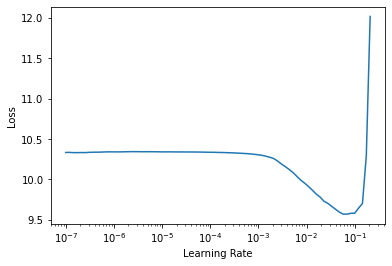

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,time
0,8.106811,6.095938,00:39
1,7.586563,6.031248,00:39


In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.17378008365631104)

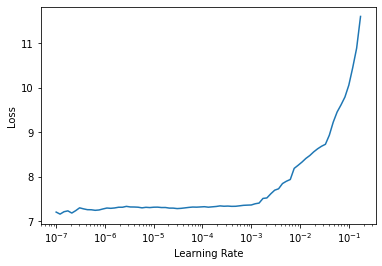

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, slice(5e-5, 5e-4))

epoch,train_loss,valid_loss,time
0,7.335484,6.138623,00:51
1,7.145704,5.996723,00:48
2,6.942595,6.087477,00:47


As we can see, even with extreme measures taken to avoid overfitting such as unfreezing batch/layer norm during fine-tuning, reducing batch size, adding weight decay, and cranking up the learning rate, the model still overfits at practically the first epoch. This probably means that the model architecture itself can be further improved, as well as the augmentation techniques. We shall explore these further in the next section on analysis.

For now, we shall save the model to experiment on the test set. 

In [ ]:
model = learn.model
save_path = 'saved_model.pt'
torch.save(model.state_dict(), save_path)